In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 


In [2]:
!python3 -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from random import choice
from array import array
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re,string,unicodedata
from bs4 import BeautifulSoup
from keras.models import load_model
from tabulate import tabulate


In [4]:
def createdf1():
  df1 = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
  return df1


In [5]:
def createdf2():

  !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
  !gunzip -c /content/aclImdb_v1.tar.gz | tar xopf /content/aclImdb_v1.tar.gz
  !cd aclImdb && mkdir movie_data
  !cd aclImdb && for split in train test; do for sentiment in pos neg; do for file in $split/$sentiment/*; do cat $file >> movie_data/full_${split}.txt; echo >> movie_data/full_${split}.txt; done; done; done;

  reviews_train = []
  for line in open('/content/aclImdb/movie_data/full_train.txt', 'r'):
      reviews_train.append(line.strip())
    
  reviews_test = []
  for line in open('/content/aclImdb/movie_data/full_test.txt', 'r'):
      reviews_test.append(line.strip())
  document = {'train': [], 'test': []} # Put the documents here
  labels = {'train': [], 'test': []} # Put the labels here

  first = 0
  last = 25000
  target = [1 if i < 12500 else 0 for i in range(first,last)]
  documents = reviews_train[first:last]
  df2 = pd.DataFrame({0:documents})
  df2[1] = target
  return df2


In [6]:
df = createdf2()

--2022-08-21 17:57:45--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  34.2MB/s    in 2.3s    

2022-08-21 17:57:48 (34.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [7]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [8]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df[0]=df[0].apply(denoise_text)

In [9]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df[0]=df[0].apply(remove_special_characters)

In [11]:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# We can use max_length=128

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


In [14]:

labels1 = []
data = []
count = 0
for i in tokenized.values:
  if len(i) <= 128:
    data.append(i)
    if count<12500:
      labels1.append(1)
    else:
      labels1.append(0)
  count += 1

tk = pd.Series(data)


In [15]:
mean_len = 0
max_len = 0
for i in tk.values:
  mean_len += len(i)
  if len(i) > max_len:
    max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tk.values])

In [ ]:
#N = len(np.array(padded)[0])

In [16]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(4589, 128)

In [17]:
k =  500;
attention_mask = np.where(padded[0:k] != 0, 1, 0)
input_ids = torch.tensor(padded[0:k])  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
features = last_hidden_states[0].numpy()

for i in range(int(len(padded)/k)):
  attention_mask = np.where(padded[(i+1)*k:(i+2)*k] != 0, 1, 0)
  input_ids = torch.tensor(padded[(i+1)*k:(i+2)*k])  
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features= np.concatenate((features,last_hidden_states[0].numpy()))
  print(i)


0
1
2
3
4
5
6
7
8


In [18]:

labels = pd.Series(labels1)
labels.value_counts()

1    2497
0    2092
dtype: int64

In [20]:
T=[]
for i in range(len(labels)):
  code = 'target = ['
  temp_code = 'labels[i],'
  for j in range(len(np.array(padded)[0])-1):
    code = code + temp_code
  code = code + 'labels[i]]'
  exec(code)
  T.append(target)

Y = np.array(T)

In [ ]:
#from array import array
Y = np.array(T)

In [21]:
np.save('/content/drive/MyDrive/rnn/features3.npy', features)
np.save('/content/drive/MyDrive/rnn/Y3.npy', Y)

In [22]:
X =  np.load('/content/drive/MyDrive/rnn/features3.npy')
Y = np.load('/content/drive/MyDrive/rnn/Y3.npy')

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y,shuffle=True)

In [24]:
from keras.activations import softmax
#Create model MTM LSTM 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN
from keras.layers import RepeatVector
from keras.layers import Softmax

n_features = 768
model = Sequential()
model.add(LSTM(train_features.shape[1], input_shape=(train_features.shape[1], n_features),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(train_features.shape[1], return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(train_features.shape[1], return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')
print(model.summary())
networkHis=model.fit(train_features, train_labels, validation_split=0.1, epochs=3, batch_size=16, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          459264    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 dense (Dense)               (None, 128, 1)            1

In [25]:

history =  networkHis.history
import matplotlib.pyplot as plt
lossess = history['loss']
val_lossess = history['val_loss']

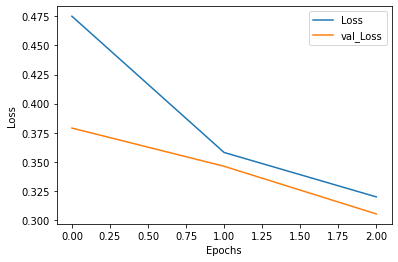

In [26]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(lossess)
plt.plot(val_lossess)
plt.legend(['Loss','val_Loss'])


In [27]:


from keras.models import load_model
 
model.save('/content/drive/MyDrive/rnn/Bert_LSTM4.h5')  # creates a HDF5 file 'my_model.h5'

In [28]:
model =load_model('/content/drive/MyDrive/rnn/Bert_LSTM4.h5')

In [29]:
pe=model.predict(test_features)

In [30]:
def makeTable(table):
  prec = []
  for i in range(table.shape[0]):
    temp1 = []
    for j in range(table.shape[1]):
      temp2 = []
      temp2.append(1-table[i][j][0])
      temp2.append(table[i][j][0])
      temp1.append(temp2)
    prec.append(temp1)
  return prec


In [31]:
prec = makeTable(pe)

In [32]:
template = model.predict(train_features)
trueTempTemplate = []
falseTempTemplate = []
numOfTrueTemplate = 100
numOfFalseTempalte = 100
sequence = [i for i in range(template.shape[0])]
i=0
while i < numOfTrueTemplate+numOfFalseTempalte:
  temp = choice(sequence)
  if train_labels[temp][0] == 1:
    if len(trueTempTemplate) < numOfTrueTemplate:
      trueTempTemplate.append(template[temp])
      i += 1
  if train_labels[temp][0] == 0:
    if len(falseTempTemplate) < numOfFalseTempalte:
      falseTempTemplate.append(template[temp])
      i += 1
falseTempTemplate = makeTable(np.array(falseTempTemplate))
trueTempTemplate = makeTable(np.array(trueTempTemplate))


In [33]:
trueTemplate = []
falseTemplate = []
for i in range(len(falseTempTemplate[0])):
  f_temp_t = 0
  t_temp_t = 0
  f_temp_f = 0
  t_temp_f = 0
  for j in range(numOfTrueTemplate):
    f_temp_t += trueTempTemplate[j][i][0]
    t_temp_t += trueTempTemplate[j][i][1]
    f_temp_f += falseTempTemplate[j][i][0]
    t_temp_f += falseTempTemplate[j][i][1]
  temp1 = []
  temp2 = []
  temp1.append(f_temp_t/numOfTrueTemplate)
  temp1.append(t_temp_t/numOfTrueTemplate)
  temp2.append(f_temp_f/numOfTrueTemplate)
  temp2.append(t_temp_f/numOfTrueTemplate)
  trueTemplate.append(temp1)
  falseTemplate.append(temp2)


In [34]:
def nearestic(table,trueTemplate,falseTemplate):
  trueTemp = 0
  falseTemp = 0
  for i in range(len(table)):
    trueTemp = trueTemp + np.square(((table[i][0] - trueTemplate[i][0])**2) +((table[i][1] - trueTemplate[i][1])**2))
    falseTemp = falseTemp + np.square(((table[i][0] - falseTemplate[i][0])**2) +((table[i][1] - falseTemplate[i][1])**2))
  if trueTemp < falseTemp:
    return 1
  else:
    return 0
  


In [41]:

parameters = {'TP':0 , 'TN':0, 'FP':0 , 'FN':0 }
for i in range(len(prec)):
  precTemp = nearestic(prec[i],trueTemplate,falseTemplate)
  type(precTemp)
  if precTemp == 1:
    if test_labels[i][0] == 1:
      parameters['TP'] += 1
    else:
      parameters['FP'] += 1
  else:
    if test_labels[i][0] == 1:
      parameters['FN'] += 1
    else:
      parameters['TN'] += 1



In [42]:
  precTemp = nearestic(prec[i],trueTemplate,falseTemplate)
  type(int(test_labels[i][0]))

int

In [ ]:
accuracy = (parameters['TP']+ parameters['TN'])/len(prec)
Precision = parameters['TP']/(parameters['TP'] + parameters['FP'])
Recall = parameters['TP'] / (parameters['TP'] + parameters['FN'] )
F_Measure = (2 * Precision * Recall) / (Precision + Recall)
table = [['parameter', 'value'], ['accuracy', accuracy], ['Precision', Precision], ['Recall', Recall],['F_Measure',F_Measure]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


╒═════════════╤══════════╕
│ parameter   │    value │
╞═════════════╪══════════╡
│ accuracy    │ 0.946864 │
├─────────────┼──────────┤
│ Precision   │ 0.952727 │
├─────────────┼──────────┤
│ Recall      │ 0.937388 │
├─────────────┼──────────┤
│ F_Measure   │ 0.944995 │
╘═════════════╧══════════╛
